In [1]:
import json
import requests
import os
file_path = os.path.join(os.getcwd(), "test_images/test_nums.json")

with open(file_path) as json_file:
  json_data = json.load(json_file)
input_data = json.dumps(json_data)
scoring_url = 'http://96c4c5ac-e9fc-4f5b-8142-33094c24aff1.centralus.azurecontainer.io/score'
headers = { 'Content-Type': 'application/json' }
response = requests.post(scoring_url, input_data, headers=headers)

print(json.loads(response.text))

[5, 7, 9, 9, 5, 9, 9, 7, 9, 5]


In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
image_path = os.path.join(os.getcwd(), 'test_images/test_num1.jpg')

def preprocess(image_path):
    img = cv.imread(image_path)
    # convert image to gray scale of pixel value from 0 to 255
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # apply gaussian blur to filter image
    blur = cv.GaussianBlur(gray,(5,5),0)
    # apply threshold on blurred image to amplify digits
    ret,thresh = cv.threshold(blur, 120, 200, cv.THRESH_BINARY_INV)    
    # find digits edges using Canny Edge Detection
    edges = cv.Canny(thresh, 120, 200)
    # apply dilation on detected edges
    kernel = np.ones((4,4),np.uint8)
    dilate = cv.dilate(edges, kernel)
    
    # find contours and get the external one
    contours, hier = cv.findContours(dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    return img, gray, blur, thresh, edges, dilate, contours

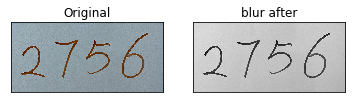

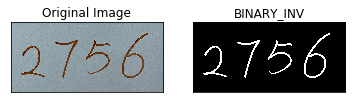

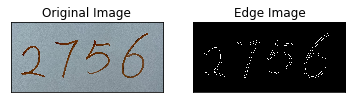

In [3]:
img, gray, blur, thresh, edges, dilate, contours = preprocess(image_path)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('blur after')
plt.xticks([]), plt.yticks([])
plt.show()

titles = ['Original Image','BINARY_INV']
images = [img, thresh]
for i in range(2):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dilate,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
from skimage import io
import numpy as np
def findBoundingBoxes(contours):
    rect = []
    # with each contour, draw boundingRect in blue
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv.boundingRect(c)
        #if w > 10 and h > 10:
        rect.append([x, y, w, h])
        # rect = np.array(rect).astype('float32')
    return rect

In [5]:
def mergeBoundingBoxes(rect):
    for i in range(len(rect)):
        j = i + 1
        while j < len(rect):
            # check if rect[j] is within rect[i]
            # print(rect[j][0], ' ', rect[i][0], ' and ', rect[j][0]+rect[j][2], ' ', rect[i][0]+rect[i][2])
            # print(rect[j][1], ' ', rect[i][1], ' and ', rect[j][1]+rect[j][3], ' ', rect[i][1]+rect[i][3])
            xBound = rect[j][0] > rect[i][0] and rect[j][0]+rect[j][2] < rect[i][0]+rect[i][2]
            yBound = rect[j][1] > rect[i][1] and rect[j][1]+rect[j][3] < rect[i][1]+rect[i][3]
            if (xBound and yBound) == True:
                rect = np.delete(rect, j, 0)
                j = i + 1
            else:
                j = j + 1
    return rect

In [6]:
rect = findBoundingBoxes(contours)
groupedRect = mergeBoundingBoxes(rect)

4


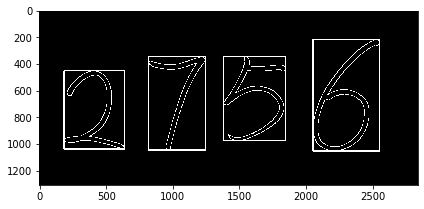

In [11]:
# draw a white rectangle to visualize the bounding rect
for row in groupedRect:
    cv.rectangle(dilate, (row[0], row[1]), (row[0]+row[2], row[1]+row[3]), (255, 0, 0), 10)
io.imshow(dilate)
print(len(groupedRect))